Task Goal
Calculate the probability of being born in Canada in a particular year, using World Bank data on:

- Birth Rate (SP.DYN.CBRT.IN) → births per 1,000 people

- Total Population (SP.POP.TOTL) → total country population per year

births = (birth_rate / 1000) * population
probability = births_canada / births_world

#### Fetch Data, world population and birth rate

In [ ]:
# fetch birth rate for all countries
import wbgapi as wb
import pandas as pd
import pprint

# population fetch
time=range(2019,2024)
economy='all'
series_totl_pop='SP.POP.TOTL'


totl_pop_country_wise_dump = wb.data.DataFrame(series_totl_pop,economy=economy,time=time,labels=True).reset_index()
print(totl_pop_country_wise_dump.head())
# pprint.pprint(totl_pop_country_wise_dump.head())

  economy                Country      YR2019      YR2020      YR2021  \
0     ZWE               Zimbabwe  15271368.0  15526888.0  15797210.0   
1     ZMB                 Zambia  18513839.0  19059395.0  19603607.0   
2     YEM            Yemen, Rep.  35111408.0  36134863.0  37140230.0   
3     PSE     West Bank and Gaza   4685306.0   4803269.0   4922749.0   
4     VIR  Virgin Islands (U.S.)    106669.0    106290.0    105870.0   

       YR2022      YR2023  
0  16069056.0  16340822.0  
1  20152938.0  20723965.0  
2  38222876.0  39390799.0  
3   5043612.0   5165775.0  
4    105413.0    104917.0  


In [12]:
#condition population data
totl_pop_country_wise = totl_pop_country_wise_dump.melt(
    id_vars=['economy','Country'],
    var_name='year',
    value_name='population'
)
totl_pop_country_wise.columns=['code','country','year','population']
totl_pop_country_wise['year']=totl_pop_country_wise['year'].str.replace('YR','').astype(int)
print(totl_pop_country_wise.head())
print(len(totl_pop_country_wise))

totl_pop_by_year = totl_pop_country_wise.groupby('year')['population'].sum().reset_index()
print(totl_pop_by_year.head())

  code                country  year  population
0  ZWE               Zimbabwe  2019  15271368.0
1  ZMB                 Zambia  2019  18513839.0
2  YEM            Yemen, Rep.  2019  35111408.0
3  PSE     West Bank and Gaza  2019   4685306.0
4  VIR  Virgin Islands (U.S.)  2019    106669.0
1330
   year    population
0  2019  8.354924e+10
1  2020  8.448114e+10
2  2021  8.531826e+10
3  2022  8.615821e+10
4  2023  8.703543e+10


In [16]:
# fetch birth rate data
time=range(2019,2024)
economy='all'
series2='SP.DYN.CBRT.IN'

birth_rate_country_wise_dump = wb.data.DataFrame(series=series2,economy=economy,time=time,labels=True).reset_index()
print(birth_rate_country_wise_dump.head())

  economy                Country  YR2019  YR2020  YR2021  YR2022  YR2023
0     ZWE               Zimbabwe  31.121  30.988  30.932  30.882  30.410
1     ZMB                 Zambia  35.006  34.408  33.930  33.542  33.081
2     YEM            Yemen, Rep.  35.947  35.895  35.668  35.407  35.209
3     PSE     West Bank and Gaza  29.708  28.877  28.225  27.575  27.062
4     VIR  Virgin Islands (U.S.)  12.300  12.100  11.800  11.600  11.400


There is a data of INX having NaN for birthrate, same is replaced with mean() of the entire column in order to keep the birthrate newtral.

In [ ]:
# condition population data
birth_rate_country_wise = birth_rate_country_wise_dump.melt(
    id_vars=['economy','Country'],
    var_name='year',
    value_name='birthrate'
)
birth_rate_country_wise.columns=['code','country','year','birthrate']
birth_rate_country_wise['year']=birth_rate_country_wise['year'].str.replace('YR','').astype(int)
print(birth_rate_country_wise.head())
print(len(birth_rate_country_wise))
na_count = birth_rate_country_wise.isna().sum().reset_index()
print(na_count)
print(birth_rate_country_wise[birth_rate_country_wise.isna().any(axis=1)])
if(birth_rate_country_wise[birth_rate_country_wise['code']=='INX']):
    birth_rate_country_wise['birthrate']= birth_rate_country_wise['birthrate'].fillna(birth_rate_country_wise['birthrate'].mean())

  code                country  year  birthrate
0  ZWE               Zimbabwe  2019     31.121
1  ZMB                 Zambia  2019     35.006
2  YEM            Yemen, Rep.  2019     35.947
3  PSE     West Bank and Gaza  2019     29.708
4  VIR  Virgin Islands (U.S.)  2019     12.300
1330
       index  0
0       code  0
1    country  0
2       year  0
3  birthrate  0
Empty DataFrame
Columns: [code, country, year, birthrate]
Index: []


Store data in sqlite database for futher calculations

In [66]:
#create data base, and create tables to store population and birthrate data
import sqlite3

conn = sqlite3.connect('mapleroot.db',isolation_level=None)
totl_pop_country_wise.to_sql('tbl_totl_county_pop',conn,if_exists='replace',index='False')
totl_pop_by_year.to_sql('tbl_totl_pop',conn,if_exists='replace',index=False)
birth_rate_country_wise.to_sql('tbl_br_cnt',conn,if_exists='replace',index=False)
print(conn.execute('SELECT name FROM sqlite_schema WHERE type="table"').fetchall())
print(conn.execute('PRAGMA TABLE_INFO("tbl_totl_pop")').fetchall())
print(conn.execute('PRAGMA TABLE_INFO("tbl_br_cnt")').fetchall())
conn.close()

[('tbl_totl_county_pop',), ('tbl_totl_pop',), ('tbl_br_cnt',)]
[(0, 'year', 'INTEGER', 0, None, 0), (1, 'population', 'REAL', 0, None, 0)]
[(0, 'code', 'TEXT', 0, None, 0), (1, 'country', 'TEXT', 0, None, 0), (2, 'year', 'INTEGER', 0, None, 0), (3, 'birthrate', 'REAL', 0, None, 0)]


In [83]:
# create a table for Canada, code, year, C_birthrate, w_birthrate, c_pop, w_pop, c_ttl_birth, w_ttl_birth, c_probability
conn = sqlite3.connect('mapleroot.db',isolation_level=None)
quary = 'SELECT * FROM tbl_br_cnt'
df_br_sql = pd.read_sql(quary,conn)
# print(df_br_sql.head())

quary = 'SELECT * FROM tbl_totl_pop'
df_ttl_pop_sql = pd.read_sql(quary,conn)
# print(df_ttl_pop_sql)

df_maple_roots = df_br_sql[df_br_sql['code']=='CAN'].reset_index()
# print(len(df_maple_roots))
# print(df_maple_roots.columns)

df_maple_roots.rename(columns={"birthrate":"c_birthyear"},inplace=True)

# column: c_pop
quary = 'SELECT * FROM tbl_totl_county_pop WHERE code="CAN"'
df_can_pop = pd.read_sql(quary,conn)
# print(df_can_pop.head())
df_maple_roots = df_maple_roots.merge(
    df_can_pop[['code','year','population']],
    on=['code','year'],
    how='left'
)
df_maple_roots.rename(columns={'population':'c_population'},inplace=True)
print(df_maple_roots.head())
conn.close()



   index code country  year  c_birthyear  c_population
0    181  CAN  Canada  2019          9.9    37618495.0
1    447  CAN  Canada  2020          9.5    38028638.0
2    713  CAN  Canada  2021          9.7    38239864.0
3    979  CAN  Canada  2022          9.0    38935934.0
4   1245  CAN  Canada  2023          8.8    40083484.0


In [84]:
# add world birth rate from table tbl_br_cnt
conn = sqlite3.connect('mapleroot.db',isolation_level=None)
quary = 'SELECT year, AVG(birthrate) AS w_birthrate FROM tbl_br_cnt GROUP BY year'
w_birthrate_df = pd.read_sql(quary,conn)
print(w_birthrate_df.head())
df_maple_roots = df_maple_roots.merge(
    w_birthrate_df[['year','w_birthrate']],
    on=['year'],
    how='left'
)
print(df_maple_roots.head())
conn.close()

   year  w_birthrate
0  2019    19.244010
1  2020    18.803416
2  2021    18.535387
3  2022    18.131408
4  2023    17.807881
   index code country  year  c_birthyear  c_population  w_birthrate
0    181  CAN  Canada  2019          9.9    37618495.0    19.244010
1    447  CAN  Canada  2020          9.5    38028638.0    18.803416
2    713  CAN  Canada  2021          9.7    38239864.0    18.535387
3    979  CAN  Canada  2022          9.0    38935934.0    18.131408
4   1245  CAN  Canada  2023          8.8    40083484.0    17.807881


In [88]:
# add world population from table tbl_totl_pop
conn = sqlite3.connect('mapleroot.db',isolation_level=None)
quary = 'SELECT year, population as w_population FROM tbl_totl_pop'
totl_pop_df = pd.read_sql(quary,conn)
print(totl_pop_df.head())
df_maple_roots = df_maple_roots.merge(
    totl_pop_df[['year','w_population']],
    on=['year'],
    how='left'
)
print(df_maple_roots.head())
conn.close()

   year  w_population
0  2019  8.354924e+10
1  2020  8.448114e+10
2  2021  8.531826e+10
3  2022  8.615821e+10
4  2023  8.703543e+10
   index code country  year  c_birthyear  c_population  w_birthrate  \
0    181  CAN  Canada  2019          9.9    37618495.0    19.244010   
1    447  CAN  Canada  2020          9.5    38028638.0    18.803416   
2    713  CAN  Canada  2021          9.7    38239864.0    18.535387   
3    979  CAN  Canada  2022          9.0    38935934.0    18.131408   
4   1245  CAN  Canada  2023          8.8    40083484.0    17.807881   

   w_population  
0  8.354924e+10  
1  8.448114e+10  
2  8.531826e+10  
3  8.615821e+10  
4  8.703543e+10  


In [ ]:
# correct error on column name
df_maple_roots.rename(columns={'c_birthyear':'c_birthrate'},inplace=True)
print(df_maple_roots.head())

   index code country  year  c_birthrate  c_population  w_birthrate  \
0    181  CAN  Canada  2019          9.9    37618495.0    19.244010   
1    447  CAN  Canada  2020          9.5    38028638.0    18.803416   
2    713  CAN  Canada  2021          9.7    38239864.0    18.535387   
3    979  CAN  Canada  2022          9.0    38935934.0    18.131408   
4   1245  CAN  Canada  2023          8.8    40083484.0    17.807881   

   w_population  
0  8.354924e+10  
1  8.448114e+10  
2  8.531826e+10  
3  8.615821e+10  
4  8.703543e+10  


### calculation
total Canada birth, total world birth, then calculate probability of birth in Canada compared to world

In [94]:
# calculate total birth in Canada
df_maple_roots['c_birth'] = (df_maple_roots['c_birthrate'] * df_maple_roots['c_population'])/1000
df_maple_roots['w_birth'] = (df_maple_roots['w_birthrate'] * df_maple_roots['w_population'])/1000
df_maple_roots['c_probability'] = (df_maple_roots['c_birth'] / df_maple_roots['w_birth'])
print(df_maple_roots.head())

   index code country  year  c_birthrate  c_population  w_birthrate  \
0    181  CAN  Canada  2019          9.9    37618495.0    19.244010   
1    447  CAN  Canada  2020          9.5    38028638.0    18.803416   
2    713  CAN  Canada  2021          9.7    38239864.0    18.535387   
3    979  CAN  Canada  2022          9.0    38935934.0    18.131408   
4   1245  CAN  Canada  2023          8.8    40083484.0    17.807881   

   w_population      c_birth       w_birth  c_probability  
0  8.354924e+10  372423.1005  1.607822e+09       0.000232  
1  8.448114e+10  361272.0610  1.588534e+09       0.000227  
2  8.531826e+10  370926.6808  1.581407e+09       0.000235  
3  8.615821e+10  350423.4060  1.562170e+09       0.000224  
4  8.703543e+10  352734.6592  1.549917e+09       0.000228  


<BarContainer object of 5 artists>

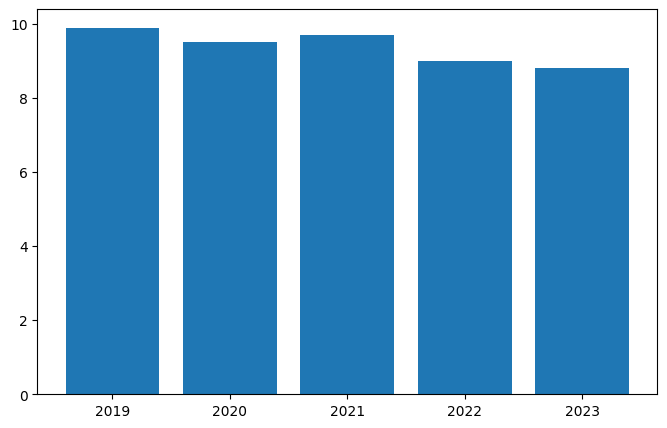

In [97]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(df_maple_roots['year'], df_maple_roots['c_birthrate'])

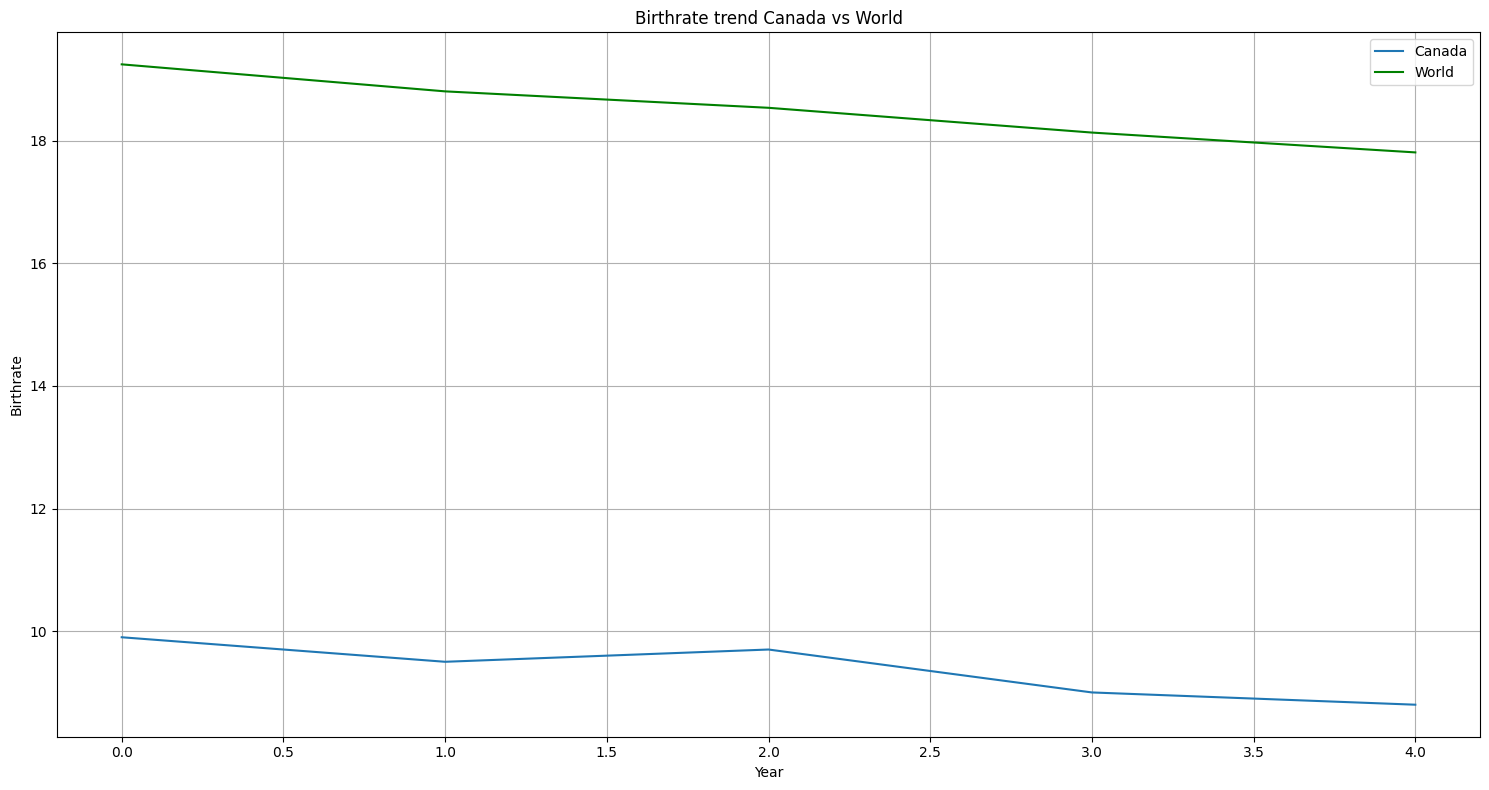

In [108]:
plt.figure(figsize=(15,8))
plt.plot(df_maple_roots['c_birthrate'],label=df_maple_roots['country'].iloc[0])
plt.plot(df_maple_roots['w_birthrate'],label='World',color='green')

plt.title("Birthrate trend Canada vs World")
plt.ylabel("Birthrate")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# calculate percentage of growth
df_maple_roots['c_birth_growth'] = df_maple_roots['c_birth'].pct_change()
print(df_maple_roots.head())

   index code country  year  c_birthrate  c_population  w_birthrate  \
0    181  CAN  Canada  2019          9.9    37618495.0    19.244010   
1    447  CAN  Canada  2020          9.5    38028638.0    18.803416   
2    713  CAN  Canada  2021          9.7    38239864.0    18.535387   
3    979  CAN  Canada  2022          9.0    38935934.0    18.131408   
4   1245  CAN  Canada  2023          8.8    40083484.0    17.807881   

   w_population      c_birth       w_birth  c_probability  c_birth_growth  
0  8.354924e+10  372423.1005  1.607822e+09       0.000232             NaN  
1  8.448114e+10  361272.0610  1.588534e+09       0.000227       -0.029942  
2  8.531826e+10  370926.6808  1.581407e+09       0.000235        0.026724  
3  8.615821e+10  350423.4060  1.562170e+09       0.000224       -0.055276  
4  8.703543e+10  352734.6592  1.549917e+09       0.000228        0.006596  


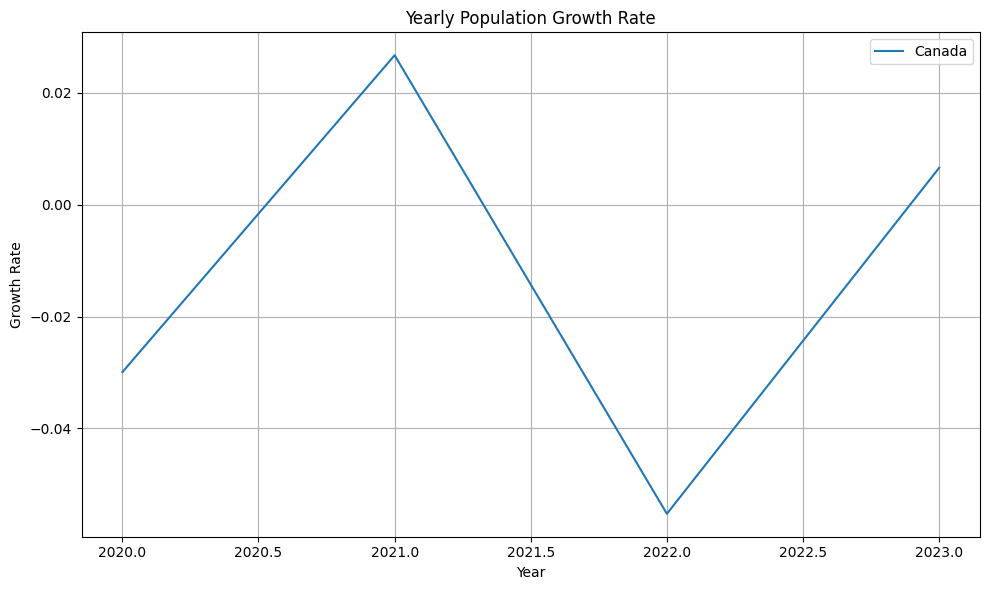

In [ ]:
# plot growth rate
plt.figure(figsize=(10,6))
plt.plot(df_maple_roots['year'],df_maple_roots['c_birth_growth'], label=df_maple_roots['country'].iloc[0])

plt.title("Yearly Population Growth Rate")
plt.ylabel("Growth Rate")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()